In [ ]:
!pip install optuna
!pip install transformers
!pip install torch
!pip install sentencepiece

#
#



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 4.1 MB/s 
     |████████████████████████████████| 81 kB 9.0 MB/s 
     |████████████████████████████████| 209 kB 47.5 MB/s 
     |████████████████████████████████| 78 kB 6.7 MB/s 
     |████████████████████████████████| 49 kB 4.9 MB/s 
     |████████████████████████████████| 112 kB 44.8 MB/s 
     |████████████████████████████████| 147 kB 53.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=2acbea5997813e13b200744faae6d48d935a6e9254da94d3bcd17cee5194bcbf
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 4.0 MB/s 
     |████████████████████████████████| 120 kB 55.3 MB

In [ ]:
################ NOTES ####################
#
#  - see ensemble https://www.kaggle.com/code/gilfernandes/commonlit-pytorch-ensemble-large/notebook 
#  - following is based on https://github.com/gilfernandes/commonlit
#  - original notebook at https://github.com/gilfernandes/commonlit/blob/main/72_pytorch_transformers_deberta_optuna.ipynb
#  - see article at https://signal.onepointltd.com/post/102h4el/modern-natural-language-processing-on-kaggle
#  - guide to HF scheduler and differential learning rate https://www.kaggle.com/code/rhtsingh/guide-to-huggingface-schedulers-differential-lrs/notebook
#  - learning rate schedulers https://www.kaggle.com/code/snnclsr/learning-rate-schedulers
#  - optuna toy example https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.pyc
#  - K-Folding, https://cran.r-project.org/web/packages/cvms/vignettes/picking_the_number_of_folds_for_cross-validation.html
#  - deberta-v2 documentation: https://huggingface.co/transformers/v4.7.0/model_doc/deberta_v2.html
#  - torch optimization documentation, to adjust activation and learning scheduler https://alband.github.io/doc_view/optim.html
#  - HF, optimization docs, https://huggingface.co/docs/transformers/main_classes/optimizer_schedules
#
#
###########################################



import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 

import gc, warnings, random, time, os

from pathlib import Path

from tqdm.notebook import tqdm

warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW
from transformers import AutoModel, AutoTokenizer, AutoConfig
from transformers import get_cosine_with_hard_restarts_schedule_with_warmup, get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import seaborn as sns

import gc
gc.enable()

import optuna

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

### Folders and Dataframes

In [ ]:
class Config(): 
    NUM_FOLDS = 6
    NUM_EPOCHS = 3
    BATCH_SIZE = 8 #was 16
    MAX_LEN = 512 # was 248
    EVAL_SCHEDULE = [(0.50, 16), (0.49, 8), (0.48, 4), (0.47, 2), (-1., 1)]
    MODEL_PATH = "/content/gdrive/My Drive/feedback-prize-english-language-learning/deberta-v3-base"
    model = "microsoft/deberta-v3-base"
    TOKENIZER_PATH = '/home/commonlit/models/deberta-large-lm/best_lm'
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    SEED = 3
    NUM_WORKERS = 2
    MODEL_FOLDER = ""
    model_name = 'deberta-v3-base'
    svm_kernels = ['rbf']
    svm_c = 5
    target_cols=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']

cfg = Config()

In [ ]:
# ====================================================
# Directory settings
# ====================================================
import os
# Import from GoogleDrive
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("//content/gdrive/MyDrive/feedback-prize-english-language-learning")

save_dir = "/content/gdrive/My Drive/feedback-prize-english-language-learning/submission"
logs_dir = "/content/gdrive/My Drive/feedback-prize-english-language-learning/logs"
data_dir = "/content/gdrive/My Drive/feedback-prize-english-language-learning"
model_dir = "/content/gdrive/My Drive/feedback-prize-english-language-learning/deberta-v3-base"

import os.path
from os import path

model_folder = cfg.model.replace('/', '-')
if path.exists(data_dir + "/" + "trained_" + model_folder) == False:
  os.mkdir(data_dir + "/" + "trained_" + model_folder)
save_model_dir = data_dir + "/" + "trained_" + model_folder

#OUTPUT_DIR = './'
#if not os.path.exists(OUTPUT_DIR):
#    os.makedirs(OUTPUT_DIR)

DATA_PATH = data_dir
cfg.MODELS_PATH = model_dir

'''
DATA_PATH = Path('/home/commonlit/data/')
assert DATA_PATH.exists()
MODELS_PATH = Path('/home/commonlit/models/')
if not MODELS_PATH.exists():
    os.mkdir(MODELS_PATH)
assert MODELS_PATH.exists()
'''

Mounted at /content/gdrive


"\nDATA_PATH = Path('/home/commonlit/data/')\nassert DATA_PATH.exists()\nMODELS_PATH = Path('/home/commonlit/models/')\nif not MODELS_PATH.exists():\n    os.mkdir(MODELS_PATH)\nassert MODELS_PATH.exists()\n"

In [ ]:
train_df = pd.read_csv(DATA_PATH + '/train.csv')
test_df = pd.read_csv(DATA_PATH + '/test.csv')
sample_df = pd.read_csv(DATA_PATH + '/sample_submission.csv')

In [ ]:
def remove_unnecessary(df):
    df.drop(df[df['syntax'] == 0].index, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
remove_unnecessary(train_df)

In [ ]:
train_df

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5
...,...,...,...,...,...,...,...,...
3906,FFD29828A873,I believe using cellphones in class for educat...,2.5,3.0,3.0,3.5,2.5,2.5
3907,FFD9A83B0849,"Working alone, students do not have to argue w...",4.0,4.0,4.0,4.0,3.5,3.0
3908,FFDC4011AC9C,"""A problem is a chance for you to do your best...",2.5,3.0,3.0,3.0,3.5,3.0
3909,FFE16D704B16,Many people disagree with Albert Schweitzer's ...,4.0,4.5,4.5,4.0,4.5,4.5


### Config and Seeding

In [ ]:
#if not cfg.MODEL_FOLDER.exists():
#    os.mkdir(cfg.MODEL_FOLDER)

In [ ]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    os.environ["PYTHONHASHSEED"] = str(random_seed)

    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

    torch.backends.cudnn.deterministic = True

### Dataset

In [ ]:
def add_bins(train_df, num_bins):
    train_df.loc[:, 'bins'] = pd.cut(train_df['syntax'], bins=num_bins, labels=False)
    return num_bins

In [ ]:
add_bins(train_df, cfg.NUM_FOLDS)

6

In [ ]:
train_df.groupby(['bins'])[cfg.target_cols].agg(['count', 'mean'])

cohesion           syntax           vocabulary           phraseology  \
        count      mean  count      mean      count      mean       count   
bins                                                                        
0          40  1.612500     40  1.362500         40  1.962500          40   
1         410  2.439024    410  2.000000        410  2.693902         410   
2        2089  2.966730   2089  2.799186       2089  3.088320        2089   
3         867  3.448097    867  3.500000        867  3.491926         867   
4         388  3.813144    388  4.000000        388  3.795103         388   
5         117  4.264957    117  4.572650        117  4.448718         117   

               grammar           conventions            
          mean   count      mean       count      mean  
bins                                                    
0     1.737500      40  1.687500          40  1.612500  
1     2.450000     410  2.326829         410  2.389024  
2     2.931067    2089  2.838200        2089  2.910244  
3     3.452134     867  3.401384         867  3.427336  
4     3.829897     388  3.742268         388  3.725515  
5     4.393162     117  4.358974         117  4.354701

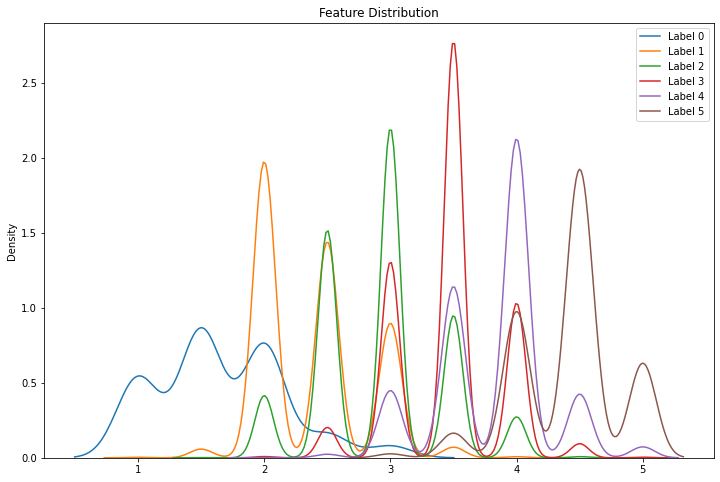

In [ ]:
import seaborn as sns

plt.figure(figsize=(12,8))
for fold in range(max(train_df["bins"])+1):
    #sns.distplot(df[df["skfold"]==fold]["syntax"],
    sns.distplot(train_df[train_df["bins"]==fold][cfg.target_cols], 
                 hist=False,
                 kde = True,
                 label = f"Label {fold}"
                )
    
plt.title(f"Feature Distribution")
plt.legend(loc="best") 
plt.show()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
'''
with open('../data/tokenizer.vocab.txt', 'w') as f:
    for k, v in tokenizer.vocab.items():
        f.write(f'{k}: {v}\n')
'''

"\nwith open('../data/tokenizer.vocab.txt', 'w') as f:\n    for k, v in tokenizer.vocab.items():\n        f.write(f'{k}: {v}\n')\n"

In [ ]:
pad_token = '______'

In [ ]:
class CommonLitDataset(Dataset):
    def __init__(self, df, tokenizer, inference_only=False):
        super().__init__()
        self.df, self.inference_only = df, inference_only
        self.text = df['full_text'].tolist()
        self.bins = df['bins']

        #is inference_only really necessary, check len of target, etc. 

        if not inference_only:
            self.target = torch.tensor(df['syntax'].to_numpy(), dtype = torch.float32)
            #self.target = torch.tensor(df[cfg.target_cols].to_numpy(), dtype = torch.float32)
        

        self.encoded = tokenizer.batch_encode_plus(
            self.text,
            padding = 'max_length',
            max_length = cfg.MAX_LEN,
            truncation = True,
            return_attention_mask=True
        )
        self.tokenizer = tokenizer
        
    def __getitem__(self, index):        
        input_ids = torch.tensor(self.encoded['input_ids'][index])
        attention_mask = torch.tensor(self.encoded['attention_mask'][index])
        
        if self.inference_only:
            return {'input_ids': input_ids, 'attention_mask': attention_mask}
        else:
            target = self.target[index]
            return {'input_ids': input_ids, 'attention_mask': attention_mask, 'target': target}
    
    def __len__(self):
        return len(self.df)

In [ ]:
sample_ds = CommonLitDataset(train_df, tokenizer)

### Model

In [ ]:
class AttentionHead(nn.Module):
    
    def __init__(self, in_features, hidden_dim, num_targets):
        super().__init__()
        self.in_features = in_features
        
        self.hidden_layer = nn.Linear(in_features, hidden_dim)
        self.final_layer = nn.Linear(hidden_dim, num_targets)
        self.out_features = hidden_dim
        
    def forward(self, features):
        att = torch.tanh(self.hidden_layer(features))
        score = self.final_layer(att)
        attention_weights = torch.softmax(score, dim=1)
        return attention_weights

In [ ]:
config = AutoConfig.from_pretrained(cfg.MODEL_PATH)

In [ ]:
config.vocab_size, tokenizer.vocab_size

(128100, 128000)

In [ ]:
from transformers import AutoModelForSequenceClassification

class CommonLitModel(nn.Module):
    def __init__(self):
        super(CommonLitModel, self).__init__()
        config = AutoConfig.from_pretrained(cfg.MODEL_PATH)
        config.update({
            "output_hidden_states": True,
            "hidden_dropout_prob": 0.0,
            "layer_norm_eps": 1e-7
        })
        self.transformer_model = AutoModelForSequenceClassification.from_pretrained(cfg.MODEL_PATH, config=config)
        self.attention = AttentionHead(config.hidden_size, 512, 1)
        self.regressor = nn.Linear(config.hidden_size, 1)
    
    def forward(self, input_ids, attention_mask):
        hidden_states = self.transformer_model(input_ids=input_ids, attention_mask=attention_mask)['hidden_states']
        last_layer_hidden_states = hidden_states[-1]
        weights = self.attention(last_layer_hidden_states)
        context_vector = torch.sum(weights * last_layer_hidden_states, dim=1) 
        return self.regressor(context_vector), context_vector

In [ ]:
sample_model = CommonLitModel()

Some weights of the model checkpoint at /content/gdrive/My Drive/feedback-prize-english-language-learning/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'mask_predictions.classifier.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

In [ ]:

'''
parameters() return the parameters in topologically sorted order: To list
model parameters in the sequence of their execution during forward pass, basically 
from input layer to the output layer. Or in the order of their execution in computation graph.

Layer Wise Learning Rate, see create_optimizer() below, 
https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2022/03/29/discriminative-lr.html

use differential learning rates based on the layers in the model, for base layers=12, large layers=18
based on a range set below base_lr and last_lr

'''

import re

for i, (name, param) in enumerate(sample_model.named_parameters()):
    if(name.find('layer') > -1):
        layer_name = re.sub(r'.+(layer\.\d+).+', r'\1', name)

In [ ]:
for i, (name, param) in enumerate(sample_model.named_parameters()):
    print(i, name, param.size())

0 transformer_model.deberta.embeddings.word_embeddings.weight torch.Size([128100, 768])
1 transformer_model.deberta.embeddings.LayerNorm.weight torch.Size([768])
2 transformer_model.deberta.embeddings.LayerNorm.bias torch.Size([768])
3 transformer_model.deberta.encoder.layer.0.attention.self.query_proj.weight torch.Size([768, 768])
4 transformer_model.deberta.encoder.layer.0.attention.self.query_proj.bias torch.Size([768])
5 transformer_model.deberta.encoder.layer.0.attention.self.key_proj.weight torch.Size([768, 768])
6 transformer_model.deberta.encoder.layer.0.attention.self.key_proj.bias torch.Size([768])
7 transformer_model.deberta.encoder.layer.0.attention.self.value_proj.weight torch.Size([768, 768])
8 transformer_model.deberta.encoder.layer.0.attention.self.value_proj.bias torch.Size([768])
9 transformer_model.deberta.encoder.layer.0.attention.output.dense.weight torch.Size([768, 768])
10 transformer_model.deberta.encoder.layer.0.attention.output.dense.bias torch.Size([768])
11 

In [ ]:
# sample_input_ids = torch.randint(0, 1000, [2, 248])
# sample_attention_mask = torch.randint(0, 1000, [2, 248])

In [ ]:
sample_records = [sample_ds[i] for i in range(2)]

In [ ]:
sample_records[0].keys()

dict_keys(['input_ids', 'attention_mask', 'target'])

In [ ]:
sample_input_ids = torch.stack([r['input_ids'] for r in sample_records])
sample_attention_mask = torch.stack([r['attention_mask'] for r in sample_records])
sample_target = torch.stack([r['target'] for r in sample_records])

In [ ]:
sample_input_ids.shape, sample_attention_mask.shape, sample_target.shape

(torch.Size([2, 512]), torch.Size([2, 512]), torch.Size([2]))

In [ ]:
sample_input_ids

tensor([[  1, 273, 428,  ...,   0,   0,   0],
        [  1, 486, 266,  ..., 479, 374,   2]])

In [ ]:
internal_out = sample_model.transformer_model(sample_input_ids, attention_mask=sample_attention_mask)

In [ ]:
internal_out.keys()

odict_keys(['logits', 'hidden_states'])

In [ ]:
len(internal_out.hidden_states), internal_out.hidden_states[-1].shape

(13, torch.Size([2, 512, 768]))

In [ ]:
sample_res = sample_model(sample_input_ids, sample_attention_mask)

In [ ]:
sample_res[0].shape, sample_res[1].shape

(torch.Size([2, 1]), torch.Size([2, 768]))

In [ ]:
torch.sum(torch.randn([8, 496, 768]), axis=1)

tensor([[  1.7711, -13.9977,  -5.0611,  ...,  -2.6052,  -7.4638, -17.4571],
        [ -4.6843,  16.3795, -35.6908,  ..., -57.1498,  -9.9274,   3.7000],
        [ 21.4383, -34.1507,  -1.3559,  ...,   6.7833, -20.1302,  18.0184],
        ...,
        [ -8.8758, -17.4992,  34.6939,  ...,  -2.3758, -18.4880,  15.7974],
        [ 23.5820,  36.7930,  10.4988,  ...,  -2.7897, -26.2732, -17.4451],
        [-21.4052,  30.7723,   4.1797,  ...,  -2.3608, -11.8757,  22.8453]])

### Evaluation and Prediction

In [ ]:
def eval_mse(model, data_loader):
    model.eval()
    mse_sum = 0
    mse_loss = nn.MSELoss(reduction='sum')
    
    with torch.no_grad():
        for batch_num, record in enumerate(data_loader):
            input_ids, attention_mask, target = record['input_ids'].to(cfg.DEVICE), record['attention_mask'].to(cfg.DEVICE), record['target'].to(cfg.DEVICE)
            pred, _ = model(input_ids, attention_mask)
            mse_sum += mse_loss(pred.flatten().cpu(), target.cpu())
            
    return mse_sum / len(data_loader.dataset)

In [ ]:
def predict(model, data_loader):
    model.eval()
    result = []
    
    with torch.no_grad():
        for batch_num, record in tqdm(enumerate(data_loader), total=len(data_loader)):
            input_ids, attention_mask = record['input_ids'].to(cfg.DEVICE), record['attention_mask'].to(cfg.DEVICE)
            pred, _ = model(input_ids, attention_mask)
            result.extend(pred.flatten().to("cpu").tolist())
            
    return np.array(result)

In [ ]:
sample_dl = DataLoader(sample_ds, shuffle=False, batch_size=16, num_workers=1)

### Optimizer and Sampler

In [ ]:
def create_optimizer(model, base_lr=5e-5, last_lr=None):
    
    #layer wise learning. numerical arguments are from model.named_parameters, see above for list
    named_parameters = list(model.named_parameters())
    
    attention_param_start = 194 #end of last layer, 0-11 layers, layer 11 end
    regressor_param_start = 206 #named parameter regressor.weight
    roberta_parameters = named_parameters[:198] #transformer_model.pooler.dense.weight
    attention_parameters = named_parameters[202:regressor_param_start] #attention.hidden_layer_weight
    regressor_parameters = named_parameters[regressor_param_start:]
    
    attention_group = [params for (name, params) in attention_parameters]
    regressor_group = [params for (name, params) in regressor_parameters]
    
    parameters = []
    if last_lr is not None:
        parameters.append({"params": attention_group, "lr": last_lr})
        parameters.append({"params": regressor_group, "lr": last_lr})
    else:
        parameters.append({"params": attention_group})
        parameters.append({"params": regressor_group})
        
    # Change on different models
    layer_low_threshold = 99
    layer_middle_threshold = 130
    
    for layer_num, (name, params) in enumerate(roberta_parameters):
        weight_decay = 0.0 if 'bias' in name else 0.01
        
        lr = base_lr / 2.5 # 2e-05
        if layer_num >= layer_middle_threshold:
            lr = base_lr / 0.5 # 1e-4
        elif layer_num >= layer_low_threshold:        
            lr = base_lr    
            
        parameters.append({"params": params,
                           "weight_decay": weight_decay,
                           "lr": lr})
        
    return AdamW(parameters)

In [ ]:
sample_optimizer = create_optimizer(sample_model)

In [ ]:
from torch.utils.data import Sampler,SequentialSampler,RandomSampler,SubsetRandomSampler
from collections import Counter

class WeightedSampler(Sampler):
    
    def __init__(self, dataset):
        
        self.indices = list(range(len(dataset)))
        self.num_samples = len(dataset)
        self.label_to_count = dict(Counter(dataset.bins))
        weights = [1/self.label_to_count[i] for i in dataset.bins]
        
        self.weights = torch.tensor(weights,dtype=torch.double)
        
    def __iter__(self):
        count = 0
        index = [self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, replacement=True)]
        while count < self.num_samples:
            yield index[count]
            count += 1
    
    def __len__(self):
        return self.num_samples

### Training

In [ ]:
def choose_eval_period(val_rmse):
    for rmse, period in cfg.EVAL_SCHEDULE:
        if val_rmse >= rmse:
            return period

In [ ]:


def serialize_best(best_val_rmse, best_epoch, val_rmse, epoch, model, model_path, lr):
    if not best_val_rmse or val_rmse < best_val_rmse:
        best_val_rmse = val_rmse
        best_epoch = epoch
        #if not model_path.parent.exists():
        #    print(model_path.parent)
        #    os.makedirs(model_path.parent)
        
#         torch.save(model.state_dict(), model_path)
        torch.save(model.state_dict(), save_model_dir + "/" + f"{cfg.model.replace('/', '-')}_fold{fold}_best.pt")
        print(f"New best_val_rmse: {best_val_rmse:0.4}")
    else:       
        print(f"Still best_val_rmse: {best_val_rmse:0.4}",
              f"(from epoch {best_epoch})")
    return best_epoch, best_val_rmse

In [ ]:
class Trainer():
    def __init__(self, lr, scaler, model, model_path, train_loader, val_loader, optimizer, scheduler=None, num_epochs=cfg.NUM_EPOCHS):
        self.lr, self.scaler, self.model, self.model_path, self.train_loader, self.val_loader, self.optimizer, self.scheduler, self.num_epochs = (
            lr, scaler, model, model_path, train_loader, val_loader, optimizer, scheduler, num_epochs
        )
            #    trainer = Trainer(lr, scaler, model, model_path, train_loader, val_loader, optimizer, scheduler = scheduler, num_epochs = epochs)
    def train(self):
        self.model.train()
        
        mse_loss = nn.MSELoss(reduction='mean')
        
        best_val_rmse = None
        best_epoch = 0
        step = 0
        last_eval_step = 0
        eval_period = cfg.EVAL_SCHEDULE[0][1]    

        start = time.time()
        val_rmse_list = []
        
        tbar = tqdm(range(self.num_epochs), total=self.num_epochs)
        for epoch in tbar:
            tbar.set_description(f'Epoch: {epoch}')
            val_rmse = None
            for batch_num, record in enumerate(self.train_loader):
                input_ids, attention_mask, target = record['input_ids'].to(cfg.DEVICE), record['attention_mask'].to(cfg.DEVICE), record['target'].to(cfg.DEVICE)
                
                self.optimizer.zero_grad()
                
                # Casts operations to mixed precision
                with torch.cuda.amp.autocast():
                    pred, _ = self.model(input_ids, attention_mask)
                    mse = mse_loss(pred.flatten(), target)
                    
                self.scaler.scale(mse).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
                
                if self.scheduler:
                    self.scheduler.step()
                    
                if step >= last_eval_step + eval_period:
                    elapsed_seconds = time.time() - start
                    num_steps = step - last_eval_step
                    print(f"\n{num_steps} steps took {elapsed_seconds:0.3} seconds")
                    last_eval_step = step
                    
                    val_rmse = np.sqrt(eval_mse(self.model, self.val_loader))
                    print(f"Epoch: {epoch} batch_num: {batch_num}", f"val_rmse: {val_rmse:0.4} ", end='')
                    
                    eval_period = choose_eval_period(val_rmse)
                    best_epoch, best_val_rmse = serialize_best(best_val_rmse, best_epoch, val_rmse, epoch, self.model, self.model_path, self.lr)
                    val_rmse_list.append(val_rmse)
                    start = time.time()
                # Finish early on condition
                if epoch > 0 and best_val_rmse > 0.6 or (len(val_rmse_list) > 5 and np.array(val_rmse_list).mean() > 1.0):
                    return best_val_rmse
                
                step += 1
        return best_val_rmse

In [ ]:
kfold = KFold(n_splits=cfg.NUM_FOLDS, random_state=cfg.SEED, shuffle=True)
splits = list(kfold.split(train_df))

### Optuna

In [ ]:
del sample_model
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Best results
# Fold 0: { 'base_lr': 0.0001190683694379101, 'last_lr': 0.00017987585986205585, 'epochs': 4 } Best value: 0.49271923303604126
# Fold 1: {'base_lr': 0.00012114635348406963, 'last_lr': 0.0005477206613438486, 'epochs': 4}. Best value:  0.45853328704833984
# Fold 2: {'base_lr': 5.24730490640746e-05, 'last_lr': 0.00020041362261812433, 'epochs': 4}   Best value:  0.49088865518569946
# Fold 3: {'base_lr': 6.108276630664184e-05, 'last_lr': 0.00011544056953737668, 'epochs': 4}. Best value:  0.4930591881275177
# Fold 4: {'base_lr': 0.0001717178883932075, 'last_lr': 0.00042448836147656634, 'epochs': 4}  Best value:  0.48955243825912476
# Fold 5: {'base_lr': 0.000135700916847811, 'last_lr': 0.0029640935672153, 'epochs': 4}.      Best value:  0.4688156247138977

In [ ]:

fold = 0

def objective(trial):
    epochs = 2  #4
    #learning rate hyperparameter tuning, in this case for layer tuning in create_optimizer() above
    base_lr = trial.suggest_float("base_lr", 3e-5, 5e-4, log=True)
    last_lr = trial.suggest_float("last_lr", 8e-5, 5e-3, log=True)
    lr = last_lr

    #tuning lr scheduler hyperparameter
    schedule_func = trial.suggest_categorical('schedule_func', [get_cosine_with_hard_restarts_schedule_with_warmup, get_cosine_schedule_with_warmup, get_linear_schedule_with_warmup])
    
    #tuning batch size hyperparameter
    batch_size = trial.suggest_categorical("batch_size", [2, 4, 8])
    
    #tuning the optimizer hyperparameter
    optimizer = trial.suggest_categorical("optimizer", ["adam", "adamw"])

    print(f'##### Using fold {fold}')
    print(f'##### Using base_lr {base_lr} last_lr {last_lr} epochs {epochs}')
    print(f'##### Using {schedule_func}')
    
    #model_path = cfg.MODEL_FOLDER + "/" + f"{cfg.model_name.replace('/', '_')}_{fold + 1}/model_{fold + 1}.pth"
    model_path = "/content/gdrive/My Drive/feedback-prize-english-language-learning/0917-deberta-v3-/microsoft-deberta-v3-base_fold2_best2.pth"
    print("Model path")
    print(model_path) #  /content/gdrive/My Drive/feedback-prize-english-language-learning/deberta-v3-base/deberta-v3-base_1/model_1.pth
    
    set_random_seed(cfg.SEED + fold)
    
    tokenizer = AutoTokenizer.from_pretrained(cfg.model_name)
    
    train_indices, val_indices = splits[fold]
    print("train_indices")
    print(len(train_indices))
    print(type(train_indices))
    train_dataset = CommonLitDataset(train_df.loc[train_indices], tokenizer) 
    print("train_dataset")
    print(len(train_dataset)) 
    print(type(train_dataset))  
    val_dataset = CommonLitDataset(train_df.loc[val_indices], tokenizer)
    print("val_dataset")
    print(len(val_dataset))
    print(type(val_dataset))
    
    train_loader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE, drop_last=False, shuffle=True, num_workers=cfg.NUM_WORKERS)    
    val_loader = DataLoader(val_dataset, batch_size=cfg.BATCH_SIZE, drop_last=False, shuffle=False, num_workers=cfg.NUM_WORKERS)
    
    model = CommonLitModel().to(cfg.DEVICE)
    #print(model.config)
    
    optimizer = create_optimizer(model, base_lr=base_lr, last_lr=last_lr)
    
    scheduler = schedule_func(optimizer, num_training_steps=cfg.NUM_EPOCHS * len(train_loader), num_warmup_steps=50) #num_warmup_steps=50
    scaler = torch.cuda.amp.GradScaler() # fp16

    
    trainer = Trainer(lr, scaler, model, model_path, train_loader, val_loader, optimizer, scheduler = scheduler, num_epochs = epochs)
    rmse_val = trainer.train()

    # Handle pruning based on the intermediate value.
    if trial.should_prune():
      raise optuna.exceptions.TrialPruned()
    
    del trainer
    del model
    del tokenizer
    del scaler
    del optimizer
    del train_loader
    del val_loader
    torch.cuda.empty_cache()
    gc.collect()

    return rmse_val #return learning rate also

In [ ]:
'''
[I 2022-09-20 22:50:25,743] Trial 2 finished with value: 0.4340265095233917 and parameters: 
{'base_lr': 6.589032198953331e-05, 'last_lr': 0.00022464473383019027, 
'schedule_func': <function get_cosine_schedule_with_warmup at 0x7f92e04fc3b0>, 
'batch_size': 2, 'optimizer': 'adamw'}. Best is trial 2 with value: 0.4340265095233917.

'''

for i in range(0, 1):
    fold = i
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=10) #n_trials=20

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))


    print(" Best value: ", study.best_trial.value)
    print(" Best  params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")


[I 2022-09-23 03:25:30,055] A new study created in memory with name: no-name-4d9a26be-ab94-42f1-bd4b-d8748943a233


##### Using fold 0
##### Using base_lr 3.577643544798571e-05 last_lr 0.0015857753780737184 epochs 2
##### Using <function get_cosine_with_hard_restarts_schedule_with_warmup at 0x7fb51fd03680>
Model path
/content/gdrive/My Drive/feedback-prize-english-language-learning/0917-deberta-v3-/microsoft-deberta-v3-base_fold2_best2.pth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


train_indices
3259
<class 'numpy.ndarray'>
train_dataset
3259
<class '__main__.CommonLitDataset'>
val_dataset
652
<class '__main__.CommonLitDataset'>


Some weights of the model checkpoint at /content/gdrive/My Drive/feedback-prize-english-language-learning/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

  0%|          | 0/2 [00:00<?, ?it/s]


16 steps took 12.3 seconds
Epoch: 0 batch_num: 16 val_rmse: 1.019 New best_val_rmse: 1.019

16 steps took 10.3 seconds
Epoch: 0 batch_num: 32 val_rmse: 0.609 New best_val_rmse: 0.609

16 steps took 10.2 seconds
Epoch: 0 batch_num: 48 val_rmse: 0.5471 New best_val_rmse: 0.5471

16 steps took 10.3 seconds
Epoch: 0 batch_num: 64 val_rmse: 0.4866 New best_val_rmse: 0.4866

4 steps took 2.55 seconds
Epoch: 0 batch_num: 68 val_rmse: 0.5889 Still best_val_rmse: 0.4866 (from epoch 0)

16 steps took 10.2 seconds
Epoch: 0 batch_num: 84 val_rmse: 0.5365 Still best_val_rmse: 0.4866 (from epoch 0)

16 steps took 10.2 seconds
Epoch: 0 batch_num: 100 val_rmse: 0.4761 New best_val_rmse: 0.4761

2 steps took 1.27 seconds
Epoch: 0 batch_num: 102 val_rmse: 0.4838 Still best_val_rmse: 0.4761 (from epoch 0)

4 steps took 2.55 seconds
Epoch: 0 batch_num: 106 val_rmse: 0.522 Still best_val_rmse: 0.4761 (from epoch 0)

16 steps took 10.2 seconds
Epoch: 0 batch_num: 122 val_rmse: 0.6181 Still best_val_rmse: 0

[I 2022-09-23 05:23:45,709] Trial 0 finished with value: 0.4334683418273926 and parameters: {'base_lr': 3.577643544798571e-05, 'last_lr': 0.0015857753780737184, 'schedule_func': <function get_cosine_with_hard_restarts_schedule_with_warmup at 0x7fb51fd03680>, 'batch_size': 2, 'optimizer': 'adam'}. Best is trial 0 with value: 0.4334683418273926.


##### Using fold 0
##### Using base_lr 0.0004919224821358357 last_lr 0.000976393727357976 epochs 2
##### Using <function get_linear_schedule_with_warmup at 0x7fb51fd03560>
Model path
/content/gdrive/My Drive/feedback-prize-english-language-learning/0917-deberta-v3-/microsoft-deberta-v3-base_fold2_best2.pth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


train_indices
3259
<class 'numpy.ndarray'>
train_dataset
3259
<class '__main__.CommonLitDataset'>
val_dataset
652
<class '__main__.CommonLitDataset'>


Some weights of the model checkpoint at /content/gdrive/My Drive/feedback-prize-english-language-learning/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

  0%|          | 0/2 [00:00<?, ?it/s]


16 steps took 11.8 seconds
Epoch: 0 batch_num: 16 val_rmse: 0.6536 New best_val_rmse: 0.6536

16 steps took 10.3 seconds
Epoch: 0 batch_num: 32 val_rmse: 0.9906 Still best_val_rmse: 0.6536 (from epoch 0)

16 steps took 10.2 seconds
Epoch: 0 batch_num: 48 val_rmse: 0.6377 New best_val_rmse: 0.6377

16 steps took 10.2 seconds
Epoch: 0 batch_num: 64 val_rmse: 0.6473 Still best_val_rmse: 0.6377 (from epoch 0)

16 steps took 10.1 seconds
Epoch: 0 batch_num: 80 val_rmse: 0.6173 New best_val_rmse: 0.6173

16 steps took 10.3 seconds
Epoch: 0 batch_num: 96 val_rmse: 0.6399 Still best_val_rmse: 0.6173 (from epoch 0)

16 steps took 10.1 seconds
Epoch: 0 batch_num: 112 val_rmse: 0.6395 Still best_val_rmse: 0.6173 (from epoch 0)

16 steps took 10.1 seconds
Epoch: 0 batch_num: 128 val_rmse: 0.6391 Still best_val_rmse: 0.6173 (from epoch 0)

16 steps took 10.1 seconds
Epoch: 0 batch_num: 144 val_rmse: 0.6411 Still best_val_rmse: 0.6173 (from epoch 0)

16 steps took 10.1 seconds
Epoch: 0 batch_num: 1

[I 2022-09-23 05:36:14,991] Trial 1 finished with value: 0.6173365712165833 and parameters: {'base_lr': 0.0004919224821358357, 'last_lr': 0.000976393727357976, 'schedule_func': <function get_linear_schedule_with_warmup at 0x7fb51fd03560>, 'batch_size': 4, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.4334683418273926.


##### Using fold 0
##### Using base_lr 0.00032909656093660627 last_lr 0.00015543854935066984 epochs 2
##### Using <function get_linear_schedule_with_warmup at 0x7fb51fd03560>
Model path
/content/gdrive/My Drive/feedback-prize-english-language-learning/0917-deberta-v3-/microsoft-deberta-v3-base_fold2_best2.pth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


train_indices
3259
<class 'numpy.ndarray'>
train_dataset
3259
<class '__main__.CommonLitDataset'>
val_dataset
652
<class '__main__.CommonLitDataset'>


Some weights of the model checkpoint at /content/gdrive/My Drive/feedback-prize-english-language-learning/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

  0%|          | 0/2 [00:00<?, ?it/s]


16 steps took 11.7 seconds
Epoch: 0 batch_num: 16 val_rmse: 0.7159 New best_val_rmse: 0.7159

16 steps took 10.2 seconds
Epoch: 0 batch_num: 32 val_rmse: 1.021 Still best_val_rmse: 0.7159 (from epoch 0)

16 steps took 10.2 seconds
Epoch: 0 batch_num: 48 val_rmse: 0.609 New best_val_rmse: 0.609

16 steps took 10.2 seconds
Epoch: 0 batch_num: 64 val_rmse: 0.5194 New best_val_rmse: 0.5194

16 steps took 10.2 seconds
Epoch: 0 batch_num: 80 val_rmse: 0.632 Still best_val_rmse: 0.5194 (from epoch 0)

16 steps took 10.1 seconds
Epoch: 0 batch_num: 96 val_rmse: 0.6222 Still best_val_rmse: 0.5194 (from epoch 0)

16 steps took 10.1 seconds
Epoch: 0 batch_num: 112 val_rmse: 0.7939 Still best_val_rmse: 0.5194 (from epoch 0)

16 steps took 10.0 seconds
Epoch: 0 batch_num: 128 val_rmse: 0.6171 Still best_val_rmse: 0.5194 (from epoch 0)

16 steps took 10.0 seconds
Epoch: 0 batch_num: 144 val_rmse: 0.6467 Still best_val_rmse: 0.5194 (from epoch 0)

16 steps took 10.1 seconds
Epoch: 0 batch_num: 160 v

[I 2022-09-23 06:00:55,144] Trial 2 finished with value: 0.5194218754768372 and parameters: {'base_lr': 0.00032909656093660627, 'last_lr': 0.00015543854935066984, 'schedule_func': <function get_linear_schedule_with_warmup at 0x7fb51fd03560>, 'batch_size': 4, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.4334683418273926.


##### Using fold 0
##### Using base_lr 0.000473478659897781 last_lr 0.0004011051991730669 epochs 2
##### Using <function get_cosine_schedule_with_warmup at 0x7fb51fd035f0>
Model path
/content/gdrive/My Drive/feedback-prize-english-language-learning/0917-deberta-v3-/microsoft-deberta-v3-base_fold2_best2.pth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


train_indices
3259
<class 'numpy.ndarray'>
train_dataset
3259
<class '__main__.CommonLitDataset'>
val_dataset
652
<class '__main__.CommonLitDataset'>


Some weights of the model checkpoint at /content/gdrive/My Drive/feedback-prize-english-language-learning/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

  0%|          | 0/2 [00:00<?, ?it/s]


16 steps took 11.8 seconds
Epoch: 0 batch_num: 16 val_rmse: 0.6364 New best_val_rmse: 0.6364

16 steps took 10.2 seconds
Epoch: 0 batch_num: 32 val_rmse: 0.9668 Still best_val_rmse: 0.6364 (from epoch 0)

16 steps took 10.1 seconds
Epoch: 0 batch_num: 48 val_rmse: 0.7604 Still best_val_rmse: 0.6364 (from epoch 0)

16 steps took 10.1 seconds
Epoch: 0 batch_num: 64 val_rmse: 0.6723 Still best_val_rmse: 0.6364 (from epoch 0)

16 steps took 10.1 seconds
Epoch: 0 batch_num: 80 val_rmse: 0.6806 Still best_val_rmse: 0.6364 (from epoch 0)

16 steps took 10.1 seconds
Epoch: 0 batch_num: 96 val_rmse: 0.6297 New best_val_rmse: 0.6297

16 steps took 10.1 seconds
Epoch: 0 batch_num: 112 val_rmse: 0.7536 Still best_val_rmse: 0.6297 (from epoch 0)

16 steps took 10.1 seconds
Epoch: 0 batch_num: 128 val_rmse: 0.6183 New best_val_rmse: 0.6183

16 steps took 10.1 seconds
Epoch: 0 batch_num: 144 val_rmse: 0.5996 New best_val_rmse: 0.5996

16 steps took 10.2 seconds
Epoch: 0 batch_num: 160 val_rmse: 0.55

[I 2022-09-23 06:25:36,737] Trial 3 finished with value: 0.5512157082557678 and parameters: {'base_lr': 0.000473478659897781, 'last_lr': 0.0004011051991730669, 'schedule_func': <function get_cosine_schedule_with_warmup at 0x7fb51fd035f0>, 'batch_size': 4, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.4334683418273926.


##### Using fold 0
##### Using base_lr 0.00029273404289147494 last_lr 0.00048113740008511144 epochs 2
##### Using <function get_cosine_with_hard_restarts_schedule_with_warmup at 0x7fb51fd03680>
Model path
/content/gdrive/My Drive/feedback-prize-english-language-learning/0917-deberta-v3-/microsoft-deberta-v3-base_fold2_best2.pth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


train_indices
3259
<class 'numpy.ndarray'>
train_dataset
3259
<class '__main__.CommonLitDataset'>
val_dataset
652
<class '__main__.CommonLitDataset'>


Some weights of the model checkpoint at /content/gdrive/My Drive/feedback-prize-english-language-learning/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

  0%|          | 0/2 [00:00<?, ?it/s]


16 steps took 11.8 seconds
Epoch: 0 batch_num: 16 val_rmse: 1.099 New best_val_rmse: 1.099

16 steps took 10.2 seconds
Epoch: 0 batch_num: 32 val_rmse: 0.8516 New best_val_rmse: 0.8516

16 steps took 10.2 seconds
Epoch: 0 batch_num: 48 val_rmse: 0.7007 New best_val_rmse: 0.7007

16 steps took 10.2 seconds
Epoch: 0 batch_num: 64 val_rmse: 0.6499 New best_val_rmse: 0.6499

16 steps took 10.2 seconds
Epoch: 0 batch_num: 80 val_rmse: 0.6519 Still best_val_rmse: 0.6499 (from epoch 0)

16 steps took 10.2 seconds
Epoch: 0 batch_num: 96 val_rmse: 0.6873 Still best_val_rmse: 0.6499 (from epoch 0)

16 steps took 10.1 seconds
Epoch: 0 batch_num: 112 val_rmse: 0.7043 Still best_val_rmse: 0.6499 (from epoch 0)

16 steps took 10.1 seconds
Epoch: 0 batch_num: 128 val_rmse: 0.792 Still best_val_rmse: 0.6499 (from epoch 0)

16 steps took 10.1 seconds
Epoch: 0 batch_num: 144 val_rmse: 0.6428 New best_val_rmse: 0.6428

16 steps took 10.2 seconds
Epoch: 0 batch_num: 160 val_rmse: 0.516 New best_val_rmse:

[I 2022-09-23 06:50:52,818] Trial 4 finished with value: 0.49653974175453186 and parameters: {'base_lr': 0.00029273404289147494, 'last_lr': 0.00048113740008511144, 'schedule_func': <function get_cosine_with_hard_restarts_schedule_with_warmup at 0x7fb51fd03680>, 'batch_size': 4, 'optimizer': 'adam'}. Best is trial 0 with value: 0.4334683418273926.


##### Using fold 0
##### Using base_lr 0.00024755780184612224 last_lr 0.0031391501996965144 epochs 2
##### Using <function get_cosine_schedule_with_warmup at 0x7fb51fd035f0>
Model path
/content/gdrive/My Drive/feedback-prize-english-language-learning/0917-deberta-v3-/microsoft-deberta-v3-base_fold2_best2.pth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


train_indices
3259
<class 'numpy.ndarray'>
train_dataset
3259
<class '__main__.CommonLitDataset'>
val_dataset
652
<class '__main__.CommonLitDataset'>


Some weights of the model checkpoint at /content/gdrive/My Drive/feedback-prize-english-language-learning/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

  0%|          | 0/2 [00:00<?, ?it/s]


16 steps took 11.8 seconds
Epoch: 0 batch_num: 16 val_rmse: 0.6153 New best_val_rmse: 0.6153

16 steps took 10.3 seconds
Epoch: 0 batch_num: 32 val_rmse: 1.473 Still best_val_rmse: 0.6153 (from epoch 0)

16 steps took 10.1 seconds
Epoch: 0 batch_num: 48 val_rmse: 0.656 Still best_val_rmse: 0.6153 (from epoch 0)

16 steps took 10.1 seconds
Epoch: 0 batch_num: 64 val_rmse: 0.6314 Still best_val_rmse: 0.6153 (from epoch 0)

16 steps took 10.1 seconds
Epoch: 0 batch_num: 80 val_rmse: 0.5719 New best_val_rmse: 0.5719

16 steps took 10.2 seconds
Epoch: 0 batch_num: 96 val_rmse: 0.6323 Still best_val_rmse: 0.5719 (from epoch 0)

16 steps took 10.2 seconds
Epoch: 0 batch_num: 112 val_rmse: 0.5712 New best_val_rmse: 0.5712

16 steps took 10.2 seconds
Epoch: 0 batch_num: 128 val_rmse: 0.752 Still best_val_rmse: 0.5712 (from epoch 0)

16 steps took 10.1 seconds
Epoch: 0 batch_num: 144 val_rmse: 0.5403 New best_val_rmse: 0.5403

16 steps took 10.2 seconds
Epoch: 0 batch_num: 160 val_rmse: 0.4911 

[I 2022-09-23 07:38:00,660] Trial 5 finished with value: 0.45539113879203796 and parameters: {'base_lr': 0.00024755780184612224, 'last_lr': 0.0031391501996965144, 'schedule_func': <function get_cosine_schedule_with_warmup at 0x7fb51fd035f0>, 'batch_size': 2, 'optimizer': 'adamw'}. Best is trial 0 with value: 0.4334683418273926.


##### Using fold 0
##### Using base_lr 4.968468501314881e-05 last_lr 8.23811562140965e-05 epochs 2
##### Using <function get_cosine_with_hard_restarts_schedule_with_warmup at 0x7fb51fd03680>
Model path
/content/gdrive/My Drive/feedback-prize-english-language-learning/0917-deberta-v3-/microsoft-deberta-v3-base_fold2_best2.pth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


train_indices
3259
<class 'numpy.ndarray'>
train_dataset
3259
<class '__main__.CommonLitDataset'>
val_dataset
652
<class '__main__.CommonLitDataset'>


Some weights of the model checkpoint at /content/gdrive/My Drive/feedback-prize-english-language-learning/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

  0%|          | 0/2 [00:00<?, ?it/s]


16 steps took 11.8 seconds
Epoch: 0 batch_num: 16 val_rmse: 0.6713 New best_val_rmse: 0.6713

16 steps took 10.3 seconds
Epoch: 0 batch_num: 32 val_rmse: 0.6161 New best_val_rmse: 0.6161

16 steps took 10.3 seconds
Epoch: 0 batch_num: 48 val_rmse: 0.558 New best_val_rmse: 0.558

16 steps took 10.3 seconds
Epoch: 0 batch_num: 64 val_rmse: 0.4626 New best_val_rmse: 0.4626

1 steps took 0.659 seconds
Epoch: 0 batch_num: 65 val_rmse: 0.5446 Still best_val_rmse: 0.4626 (from epoch 0)

16 steps took 10.2 seconds
Epoch: 0 batch_num: 81 val_rmse: 0.7135 Still best_val_rmse: 0.4626 (from epoch 0)

16 steps took 10.2 seconds
Epoch: 0 batch_num: 97 val_rmse: 0.5584 Still best_val_rmse: 0.4626 (from epoch 0)

16 steps took 10.2 seconds
Epoch: 0 batch_num: 113 val_rmse: 0.5909 Still best_val_rmse: 0.4626 (from epoch 0)

16 steps took 10.2 seconds
Epoch: 0 batch_num: 129 val_rmse: 0.6192 Still best_val_rmse: 0.4626 (from epoch 0)

16 steps took 10.2 seconds
Epoch: 0 batch_num: 145 val_rmse: 0.4828 

[I 2022-09-23 09:49:06,979] Trial 6 finished with value: 0.4365008473396301 and parameters: {'base_lr': 4.968468501314881e-05, 'last_lr': 8.23811562140965e-05, 'schedule_func': <function get_cosine_with_hard_restarts_schedule_with_warmup at 0x7fb51fd03680>, 'batch_size': 8, 'optimizer': 'adam'}. Best is trial 0 with value: 0.4334683418273926.


##### Using fold 0
##### Using base_lr 0.0002791115409978205 last_lr 9.274988470321305e-05 epochs 2
##### Using <function get_cosine_schedule_with_warmup at 0x7fb51fd035f0>
Model path
/content/gdrive/My Drive/feedback-prize-english-language-learning/0917-deberta-v3-/microsoft-deberta-v3-base_fold2_best2.pth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


train_indices
3259
<class 'numpy.ndarray'>
train_dataset
3259
<class '__main__.CommonLitDataset'>
val_dataset
652
<class '__main__.CommonLitDataset'>


Some weights of the model checkpoint at /content/gdrive/My Drive/feedback-prize-english-language-learning/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

  0%|          | 0/2 [00:00<?, ?it/s]


16 steps took 11.8 seconds
Epoch: 0 batch_num: 16 val_rmse: 1.129 New best_val_rmse: 1.129

16 steps took 10.2 seconds
Epoch: 0 batch_num: 32 val_rmse: 0.892 New best_val_rmse: 0.892

16 steps took 10.2 seconds
Epoch: 0 batch_num: 48 val_rmse: 0.7858 New best_val_rmse: 0.7858

16 steps took 10.2 seconds
Epoch: 0 batch_num: 64 val_rmse: 0.7957 Still best_val_rmse: 0.7858 (from epoch 0)

16 steps took 10.1 seconds
Epoch: 0 batch_num: 80 val_rmse: 0.6364 New best_val_rmse: 0.6364

16 steps took 10.1 seconds
Epoch: 0 batch_num: 96 val_rmse: 0.6 New best_val_rmse: 0.6

16 steps took 10.2 seconds
Epoch: 0 batch_num: 112 val_rmse: 0.6331 Still best_val_rmse: 0.6 (from epoch 0)

16 steps took 10.1 seconds
Epoch: 0 batch_num: 128 val_rmse: 0.6683 Still best_val_rmse: 0.6 (from epoch 0)

16 steps took 10.1 seconds
Epoch: 0 batch_num: 144 val_rmse: 0.6173 Still best_val_rmse: 0.6 (from epoch 0)

16 steps took 10.1 seconds
Epoch: 0 batch_num: 160 val_rmse: 0.6065 Still best_val_rmse: 0.6 (from ep

[I 2022-09-23 10:13:56,885] Trial 7 finished with value: 0.5290858149528503 and parameters: {'base_lr': 0.0002791115409978205, 'last_lr': 9.274988470321305e-05, 'schedule_func': <function get_cosine_schedule_with_warmup at 0x7fb51fd035f0>, 'batch_size': 4, 'optimizer': 'adam'}. Best is trial 0 with value: 0.4334683418273926.


##### Using fold 0
##### Using base_lr 0.00027437272047720643 last_lr 0.00014902850451245248 epochs 2
##### Using <function get_cosine_schedule_with_warmup at 0x7fb51fd035f0>
Model path
/content/gdrive/My Drive/feedback-prize-english-language-learning/0917-deberta-v3-/microsoft-deberta-v3-base_fold2_best2.pth


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


train_indices
3259
<class 'numpy.ndarray'>
train_dataset
3259
<class '__main__.CommonLitDataset'>
val_dataset
652
<class '__main__.CommonLitDataset'>


Some weights of the model checkpoint at /content/gdrive/My Drive/feedback-prize-english-language-learning/deberta-v3-base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.classifier.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (i

  0%|          | 0/2 [00:00<?, ?it/s]


16 steps took 11.8 seconds
Epoch: 0 batch_num: 16 val_rmse: 1.16 New best_val_rmse: 1.16

16 steps took 10.2 seconds
Epoch: 0 batch_num: 32 val_rmse: 0.8397 New best_val_rmse: 0.8397

16 steps took 10.1 seconds
Epoch: 0 batch_num: 48 val_rmse: 0.8024 New best_val_rmse: 0.8024

16 steps took 10.1 seconds
Epoch: 0 batch_num: 64 val_rmse: 0.8013 New best_val_rmse: 0.8013

16 steps took 10.2 seconds
Epoch: 0 batch_num: 80 val_rmse: 0.6319 New best_val_rmse: 0.6319

16 steps took 10.1 seconds
Epoch: 0 batch_num: 96 val_rmse: 0.6365 Still best_val_rmse: 0.6319 (from epoch 0)

16 steps took 10.1 seconds
Epoch: 0 batch_num: 112 val_rmse: 0.6874 Still best_val_rmse: 0.6319 (from epoch 0)

16 steps took 10.1 seconds
Epoch: 0 batch_num: 128 val_rmse: 0.6234 New best_val_rmse: 0.6234

16 steps took 10.2 seconds
Epoch: 0 batch_num: 144 val_rmse: 0.6223 New best_val_rmse: 0.6223

16 steps took 10.1 seconds
Epoch: 0 batch_num: 160 val_rmse: 0.631 Still best_val_rmse: 0.6223 (from epoch 0)

16 steps 

In [ ]:

'''

[I 2022-09-23 05:23:45,709] Trial 0 finished with value: 0.4334683418273926 and parameters: {
  'base_lr': 3.577643544798571e-05, 'last_lr': 0.0015857753780737184, 
  'schedule_func': <function get_cosine_with_hard_restarts_schedule_with_warmup at 0x7fb51fd03680>, 
  'batch_size': 2, 
  'optimizer': 'adam'}. Best is trial 0 with value: 0.4334683418273926.



%%time

for i in range(4, 5):
    fold = i
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=20)
    print(" Best value: ", study.best_trial.value)
    print(" Best params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
'''


In [ ]:
'''
for i in range(4, len(list(splits))):
    fold = i
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=20)
    print(" Best value: ", study.best_trial.value)
    print(" Best params: ")
    for key, value in study.best_trial.params.items():
        print(f"    {key}: {value}")
'''

### Verify the model

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm

In [ ]:
cfg.model_offset = 0
cfg.model_limit = 6
cfg.n_folds = 5
cfg.svm_kernels = ['rbf']
cfg.svm_c = 5

In [ ]:
num_bins = int(np.ceil(np.log2(len(train_df))))
train_df['bins'] = pd.cut(train_df['syntax'], bins=num_bins, labels=False)
bins = train_df['bins'].values

In [ ]:
%%time

inference_models = []
for i in range(1, cfg.NUM_FOLDS + 1):
    print(f'Model {i}')
    inference_model = CommonLitModel()
    inference_model = inference_model.cuda()
    inference_model.load_state_dict(torch.load(str(MODELS_PATH/f"{cfg.model_name.replace('/', '_')}_{i}/model_{i}.pth")))
    inference_model.eval();
    inference_models.append(inference_model)

In [ ]:
from transformers import RobertaTokenizer

tokenizers = []
for i in range(1, cfg.NUM_FOLDS):
    tokenizer = RobertaTokenizer.from_pretrained(MODELS_PATH + "/" + f"{cfg.model_name.replace('/', '_')}_{i}")
    tokenizers.append(tokenizer)

In [ ]:
def get_cls_embeddings(dl, transformer_model):
    cls_embeddings = []
    with torch.no_grad():
        for input_features in tqdm(dl, total=len(dl)):
            output, context_vector = transformer_model(input_features['input_ids'].cuda(), input_features['attention_mask'].cuda())
#             cls_embeddings.extend(output['last_hidden_state'][:,0,:].detach().cpu().numpy())
            embedding_out = context_vector.detach().cpu().numpy()
            cls_embeddings.extend(embedding_out)
    return np.array(cls_embeddings)

In [ ]:
def rmse_score(X, y):
    return np.sqrt(mean_squared_error(X, y))

In [ ]:
def convert_to_list(t):
    return t.flatten().long()

class CommonLitDataset(nn.Module):
    def __init__(self, text, test_id, tokenizer, max_len=128):
        self.excerpt = text
        self.test_id = test_id
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __getitem__(self,idx):
        encode = self.tokenizer(self.excerpt[idx],
                                return_tensors='pt',
                                max_length=self.max_len,
                                padding='max_length',
                                truncation=True)
        return {'input_ids': convert_to_list(encode['input_ids']),
                'attention_mask': convert_to_list(encode['attention_mask']),
                'id': self.test_id[idx]}
    
    def __len__(self):
        return len(self.excerpt)

In [ ]:
def create_dl(df, tokenizer):
    text = df['full_text'].values
    ids = df['text_id'].values
    ds = CommonLitDataset(text, ids, tokenizer, max_len=cfg.MAX_LEN)
    return DataLoader(ds, 
                      batch_size = cfg.BATCH_SIZE,
                      shuffle=False,
                      num_workers = 1,
                      pin_memory=True,
                      drop_last=False
                     )

In [ ]:
train_df = pd.read_csv(DATA_PATH + '/train-orig.csv')
test_df = pd.read_csv(DATA_PATH + '/test.csv')
remove_unnecessary(train_df)

In [ ]:
train_target_mean = train_df['syntax'].mean()
train_target_std = train_df['syntax'].std()
train_df['normalized_target'] = (train_df['syntax'] - train_target_mean) / train_target_std

In [ ]:
%%time

train_target = train_df['normalized_target'].values

def calc_mean(scores):
    return np.mean(np.array(scores), axis=0)

final_scores = []
final_rmse = []
kernel_rmse_score_mean = []
final_kernel_predictions_means = []
for j, (inference_model, tokenizer) in enumerate(zip(inference_models, tokenizers)):
    print('Model', j)
    test_dl = create_dl(test_df, tokenizer)
    train_dl = create_dl(train_df, tokenizer)
    transformer_model = inference_model
    transformer_model.cuda()
    X = get_cls_embeddings(train_dl, transformer_model)
    
    y = train_target
    X_test = get_cls_embeddings(test_dl, transformer_model)
    
    kfold = StratifiedKFold(n_splits=cfg.NUM_FOLDS)
    scores = []
    rmse_scores = []
    kernel_predictions_means = []
    for kernel in cfg.svm_kernels:
        print('Kernel', kernel)
        kernel_scores = []
        kernel_rmse_scores = []
        kernel_predictions = []
        for k, (train_idx, valid_idx) in enumerate(kfold.split(X, bins)):

            print('Fold', k, train_idx.shape, valid_idx.shape)
            model = SVR(C=cfg.svm_c, kernel=kernel, gamma='auto')

            X_train, y_train = X[train_idx], y[train_idx]
            X_valid, y_valid = X[valid_idx], y[valid_idx]
            model.fit(X_train, y_train)
            prediction = model.predict(X_valid)
            kernel_predictions.append(prediction)
            kernel_rmse_scores.append(rmse_score(prediction, y_valid))
            print('rmse_score', kernel_rmse_scores[k])
            kernel_scores.append(model.predict(X_test))
        kernel_predictions_means.append(np.array([np.mean(kp) for kp in kernel_predictions]).mean())
        scores.append(calc_mean(kernel_scores))
        kernel_rmse_score = calc_mean(kernel_rmse_scores)
        kernel_rmse_score_mean.append(kernel_rmse_score)
        rmse_scores.append(kernel_rmse_score)
    final_kernel_predictions_means.append(kernel_predictions_means)
    final_scores.append(calc_mean(scores))
    final_rmse.append(calc_mean(rmse_scores))
print('FINAL RMSE score', np.mean(np.array(final_rmse)))

In [ ]:
final_kernel_predictions_means

In [ ]:
# (train_df['target'] - cfg.train_target_mean) / cfg.train_target_std
final_scores_normalized = np.array(final_scores) * train_target_std + train_target_mean

In [ ]:
kernel_rmse_score_mean_array = np.array(kernel_rmse_score_mean)
kernel_rmse_score_mean_sum = np.sum(kernel_rmse_score_mean_array)
prop_losses = kernel_rmse_score_mean_array / kernel_rmse_score_mean_sum
prop_losses_sum = (1 - prop_losses).sum()
weights = (1 - prop_losses) / prop_losses_sum
weights

In [ ]:
def calc_mean(scores, weights=weights):
    return np.average(np.array(scores), weights=weights, axis=0)

In [ ]:
target_mean = train_df['syntax'].mean()
final_scores_flat = calc_mean(final_scores_normalized).flatten()
final_scores_mean = final_scores_flat.mean()
target_mean, np.array(final_scores_normalized).mean()
# (-0.9579984513405823, -0.8029817438292849)

In [ ]:
final_scores_flat

In [ ]:
mean_diff = target_mean - final_scores_mean
mean_diff, mean_diff / len(final_scores)

In [ ]:
sample_df['syntax'] = final_scores_flat + mean_diff
# sample_df['target'] = len(final_scores) / np.sum(1 / np.array(final_scores), axis=0) # harmonic mean
sample_df

### Prepare Packaging

In [ ]:
cfg.model_name

In [ ]:
BEST_MODEL_FOLDER = MODELS_PATH/cfg.model_name/'best'
!rm -rf {BEST_MODEL_FOLDER}
!mkdir -p {BEST_MODEL_FOLDER}

In [ ]:
BEST_MODEL_FOLDER

In [ ]:
cfg.NUM_FOLDS

In [ ]:
bestmodels = [MODELS_PATH/f'{cfg.model_name}_{i + 1}' for i in range(0, cfg.NUM_FOLDS)]

In [ ]:
bestmodels

In [ ]:
from shutil import copyfile

def normalize_name(path_name):
    return path_name.replace('', '')

for i, best_model in enumerate(bestmodels):
    print(f'Processing {i}th model')
    i = i + 1
    best_model_file = f'{best_model}/model_{i}.pth'
    if Path(best_model_file).exists():
        copyfile(best_model_file, f'{BEST_MODEL_FOLDER}/{i}_pytorch_model.bin')
        tokenizer_path = Path(BEST_MODEL_FOLDER/f'tokenizer-{i}')
        tokenizer_path.mkdir(parents=True, exist_ok=True)
        assert tokenizer_path.exists()

        tokenizer_json = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}_{i}/tokenizer_config.json'))
        assert tokenizer_json.exists(), f'{tokenizer_json} does not exist'
        copyfile(tokenizer_json, tokenizer_path/'tokenizer.json')

        vocab_txt = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}_{i}/vocab.json'))
        assert vocab_txt.exists(), f'{vocab_txt} does not exist'
        copyfile(vocab_txt, tokenizer_path/'vocab.json')

        merges = Path(normalize_name(f'{MODELS_PATH/cfg.model_name}_{i}/merges.txt'))
        assert merges.exists()
        copyfile(merges, tokenizer_path/'merges.txt')
    else:
        print(f'{best_model_file} is missing')

In [ ]:
import shutil

shutil.make_archive(MODELS_PATH/cfg.model_name/'best_models', 'zip', BEST_MODEL_FOLDER)

In [ ]:
!ls {MODELS_PATH/cfg.model_name}

In [ ]:
!mv {MODELS_PATH}/{cfg.model_name}.yaml {MODELS_PATH/cfg.model_name}

In [ ]:
transformer_model.transformer_model.save_pretrained(save_directory=f'{MODELS_PATH/cfg.model_name}/lm')

In [ ]:
!du -h {MODELS_PATH/cfg.model_name}/*

In [ ]:
shutil.make_archive(MODELS_PATH/cfg.model_name/'lm', 'zip', f'{MODELS_PATH/cfg.model_name}/lm')

In [ ]:
!kaggle datasets init -p {MODELS_PATH/cfg.model_name}

In [ ]:
dataset_json_path = Path(MODELS_PATH/cfg.model_name/'dataset-metadata.json')
assert dataset_json_path.exists()

In [ ]:
!cat {str(dataset_json_path)}

In [ ]:
with open(dataset_json_path, 'r') as f:
    dataset_json = f.read()
    dataset_json = dataset_json.replace('INSERT_TITLE_HERE', f'commonlit-{cfg.model_name}-light').replace('INSERT_SLUG_HERE', f'commonlit-{cfg.model_name}-light')
    print(dataset_json)
with(open(dataset_json_path, 'w')) as f:
    f.write(dataset_json)

In [ ]:
!rm -rf {MODELS_PATH/cfg.model_name}/best
!rm -rf {MODELS_PATH/cfg.model_name}/lm

In [ ]:
!kaggle datasets create -p {MODELS_PATH/cfg.model_name}

In [ ]:
!kaggle datasets version -p {MODELS_PATH/cfg.model_name} -m "Version with merges.txt" -d

In [ ]:
state_dict = torch.load(str(MODELS_PATH/f'distilroberta-0/checkpoint-105/pytorch_model.bin'))

In [ ]:
loaded_model = CommonLitModel()

In [ ]:
loaded_model.load_state_dict(state_dict)